-----------------------------------------------------------------------------------------
*Titanic 생존자 예측*

---
## Titanic 생존자 예측
---
### Predict Survival on the Titanic
- Defining the problem sttement
- Collecting the data
- Explo

In [1084]:
from IPython.display import Image
Image(url='https://img.mbn.co.kr/filewww/news/2022/01/24/164300220861ee39602b4c5.jpg')

#### 2. 데이터
- 판다스 사용
    - train data
    - test data

In [1085]:
import pandas as pd
import numpy as np
import random as rnd
import xgboost as xgb 

In [1086]:
# 학습에 사용할 데이터 => 모델 생성
train= pd.read_csv('../타이타닉/train.csv')
# 모델 검증 사용할 데이터 
test = pd.read_csv('../타이타닉/test.csv')

#### 탐색적 데이터 분석(EDA)

In [1087]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [1088]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


#### Data Dictionary
- Sirvived : 생존 여부, 0=No, 1= Yes => 답 

In [941]:
for col in dataset:
    print(col,":")
    print("numbers of null:",dataset[col].isnull().sum())
    print("dtype:",dataset[col].dtype)
    print("#"*10)

     PassengerId  Survived  Pclass   
0              1         0       3  \
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp   
0                              Braund, Mr. Owen Harris    male  22.0      1  \
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ... 

TypeError: list indices must be integers or slices, not DataFrame

In [1089]:
train[train['Pclass']==1]['Cabin'].isnull().sum(),train[train['Pclass']==2]['Cabin'].count()

(40, 16)

In [1090]:
def class_ratio(num):
    class_nan = train[train['Pclass']==1]['Cabin'].isnull().sum()
    class_cnt = train[train['Pclass']==1]['Cabin'].count()
    class_sum = class_nan + class_cnt
    class_ratio = class_nan / class_sum
    print(num,f'등칸 NaN 비율 : {0:.4f}'.format(class_ratio))

In [1091]:
class_ratio(1), class_ratio(2), class_ratio(3)

1 등칸 NaN 비율 : 0.0000
2 등칸 NaN 비율 : 0.0000
3 등칸 NaN 비율 : 0.0000


(None, None, None)

In [1092]:
# Name값에서 성별 정보 추출
# 정규표현식으로 [문자]. 으로 끝나는 문자열 추출
train_test_data = [train,test]
for dataset in train_test_data:
    dataset['Title'] = dataset['Name'].str.extract('([A-za-z]+)\.', expand=False)

In [1094]:
train.Title.value_counts()

Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: count, dtype: int64

In [1095]:
numbers=train.Title.value_counts()

In [1096]:
groups=train.groupby(["Survived",'Title'])

In [1097]:
title_mapping = {
      'Mr' : 0
    , 'Miss' : 1
    , 'Mrs' : 2
    , 'Master' : 3
    , 'Dr' : 4
    , 'Rev' : 4
    , 'Mlle' : 4
    , 'Major' : 4
    , 'Col' : 4
    , 'Countess' : 4
    , 'Capt' : 4
    , 'Ms' : 4
    , 'Sir' : 4
    , 'Lady' : 4
    , 'Mme' : 4
    , 'Don' : 4
    , 'Jonkheer' : 4
}

train['Title'] = train['Title'].map(title_mapping)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [981]:
probability


{' Capt': 1.0,
 ' Col': 0.5,
 ' Don': 1.0,
 ' Dr': 0.5714285714285714,
 ' Jonkheer': 1.0,
 ' Major': 0.5,
 ' Master': 0.425,
 ' Miss': 0.3021978021978022,
 ' Mr': 0.8433268858800773,
 ' Mrs': 0.208,
 ' Rev': 1.0}

In [1099]:
print(train.Title.isnull().sum())
train.Title.fillna(1,inplace=True)


print(test.Title.isnull().sum())
test.Title.fillna(1,inplace=True)

0
0


In [1116]:
sex={'male':0,"female":1}
train['Sex']=train['Sex'].map(sex)
test['Sex'] = test['Sex'].map(sex)

#### Data Dictionary
##### 컬럼 의미 파악 
- Survived : 생존 여부, 0=No, 1=Yes => 답
- Pclass : 등급 => 1,2,3
- sibsp : 형재, 동승자(부부)
- parch : 부모, 자식
- cabin : 방번호 
-embarked : 선착장 => C , Q, S

In [1117]:
# 탐색 
# 구조 파악
# 학습에 사용할 데이터 
train.shape 
# (행, 열)

(891, 13)

In [1118]:
test.shape

(418, 13)

In [1119]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family
0,892,3,"Kelly, Mr. James",NaN,34.5,0,0,330911,7.8292,NaN,2,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",NaN,47.0,1,0,363272,7.0000,NaN,1,2,1
2,894,2,"Myles, Mr. Thomas Francis",NaN,62.0,0,0,240276,9.6875,NaN,2,0,0
3,895,3,"Wirz, Mr. Albert",NaN,27.0,0,0,315154,8.6625,NaN,1,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",NaN,22.0,1,1,3101298,12.2875,NaN,1,2,2


In [1120]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          0 non-null      float64
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  Title        891 non-null    int64  
dtypes: float64(3), int64(6), object(4)
memory usage: 90.6+ KB


In [1121]:
# 결측치 확인
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex            891
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            0
dtype: int64

In [1122]:
train.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Title
count,891.000000,891.000000,891.000000,0.0,714.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,NaN,29.699118,0.523008,0.381594,32.204208,0.740741
std,257.353842,0.486592,0.836071,NaN,14.526497,1.102743,0.806057,49.693429,1.052077
min,1.000000,0.000000,1.000000,NaN,0.420000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,NaN,20.125000,0.000000,0.000000,7.910400,0.000000
50%,446.000000,0.000000,3.000000,NaN,28.000000,0.000000,0.000000,14.454200,0.000000
75%,668.500000,1.000000,3.000000,NaN,38.000000,1.000000,0.000000,31.000000,1.000000
max,891.000000,1.000000,3.000000,NaN,80.000000,8.000000,6.000000,512.329200,4.000000


In [1123]:
train.describe(include=['O'])

,Name,Ticket,Cabin,Embarked
count,891,891,204,889
unique,891,681,147,3
top,"Braund, Mr. Owen Harris",347082,B96 B98,S
freq,1,7,4,644


In [1124]:
train[['Pclass','Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


C:\Users\tprud\AppData\Local\Temp\ipykernel_3324\3543593124.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns. distplot(dataset['Fare'],hist=False)


Q1= 7.8958
Q3= 31.471875
median= 14.4542
mean= 35.57653540669856
numbers outliers 31


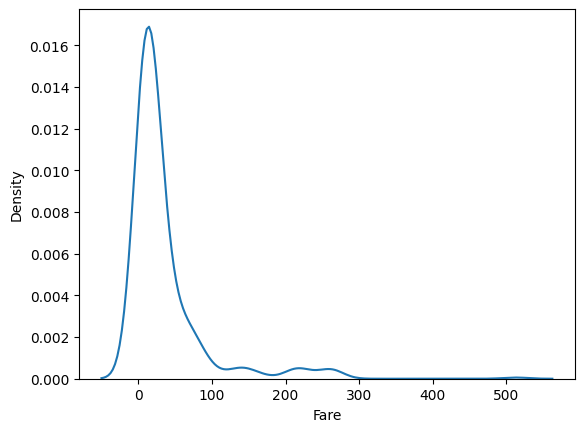

In [1125]:
import seaborn as sns
sns. distplot(train['Fare'],hist=False)

quratiles=np.nanpercentile(train['Fare'],[25,50,75])
Q1=quratiles[0]
Q3=quratiles[2]
mean=np.nanmean(train["Fare"])
med=np.nanmedian(train['Fare'])
IQR=(Q3-Q1)*3
low=Q1-IQR
high=Q3+IQR
print('Q1=',Q1)
print("Q3=",Q3)
print('median=',med)
print("mean=",mean)
print('numbers outliers',sum(train['Fare']<low)+sum(datas['Fare']>high))

C:\Users\tprud\AppData\Local\Temp\ipykernel_3324\1721310600.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset['Age'],hist=False)


<Axes: xlabel='Age', ylabel='Density'>

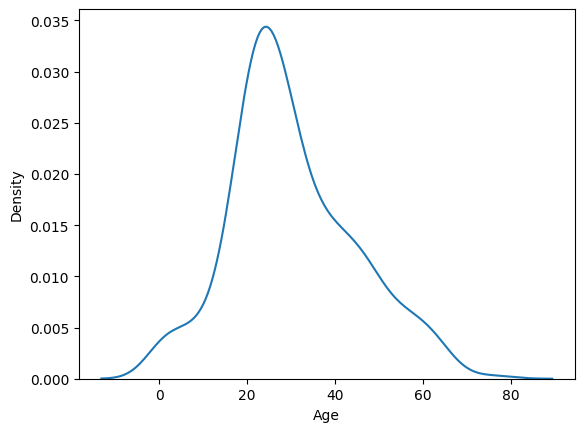

In [1126]:
sns.distplot(dataset['Age'],hist=False)

In [1127]:
dataset.Fare.fillna(np.nanmedian(dataset.Fare),inplace=True)

In [1128]:
dataset['Family']=dataset['SibSp']+dataset['Parch']

In [1129]:
E={'S':1,'Q':2,'C':3}
dataset.Embarked=dataset.Embarked.map(E)
dataset.Embarked.fillna(1,inplace=True)

In [1114]:
numbers=train.Ticket.value_counts()
group=dataset.groupby(["Survived","Ticket"])


KeyError: 'Survived'

In [ ]:
dataset.Ticket.fillna(1,inplace=True)

In [ ]:
ind=dataset.Ticket.value_counts().index
count=0
freq={}
for i in dataset.Ticket.value_counts():
    freq[ind[count]]=i
    count+=1
dataset['Ticket']=dataset.Ticket.map(freq)

In [ ]:
ind=dataset.Cabin.value_counts().index
count=0
freq={}
for i in dataset.Cabin.value_counts():
    freq[ind[count]]=i
    count+=1
dataset['Cabin']=dataset.Cabin.map(freq)

In [ ]:
dataset.Cabin.fillna(0,inplace=True)

In [ ]:
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,1,7.2500,0.0,1.0,0.843327,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,2,71.2833,2.0,3.0,0.208000,1
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,1,7.9250,0.0,1.0,0.302198,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,2,53.1000,2.0,1.0,0.208000,1
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,1,8.0500,0.0,1.0,0.843327,0


In [ ]:
train=dataset[dataset.Age.notnull()]

## 데이터 시각화


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
from scipy import stats

## Bar Chart for Categorical Features(Column) : 변수들의 생존 관련성 
- Pclass
- Sex
- SibSp
- Parch
- Embarked
- Cabin

In [ ]:
# pclass vs. survived
survived = train[train['Survived']==1]['Pclass'].value_counts()
survived

Pclass
1    122
3     85
2     83
Name: count, dtype: int64

In [ ]:
dead = train[train['Survived']==0]['Pclass'].value_counts()
dead

Pclass
3    270
2     90
1     64
Name: count, dtype: int64

<Axes: >

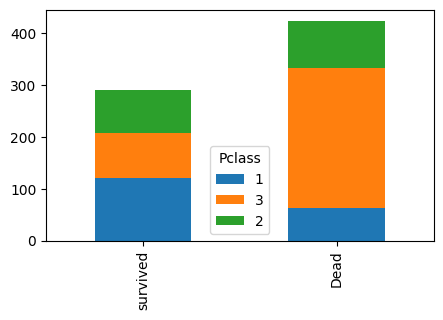

In [ ]:
df = pd.DataFrame([survived,dead])
df.index = ['survived','Dead']
df.plot(kind='bar', stacked=True, figsize=(5,3))   #stacked는 쌓아서 비교하는것 

In [ ]:
# Function
def bar_chart(feature):
    '''
    desc : 특정 변수들의 생존 관련성 시각화

    parameter : 
    feature : 컬럼 =>Pclass, sex , Sibsp, Parch, Embarked, Cabin
    '''

    survived = train[train['Survived']==1][feature].value_counts()
    dead = train[train['Survived']==0][feature].value_counts()
    df = pd.DataFrame([survived, dead])
    df.index = ['Survived', 'dead']
    df.plot(kind='bar', stacked=True, figsize=(10,6)) 

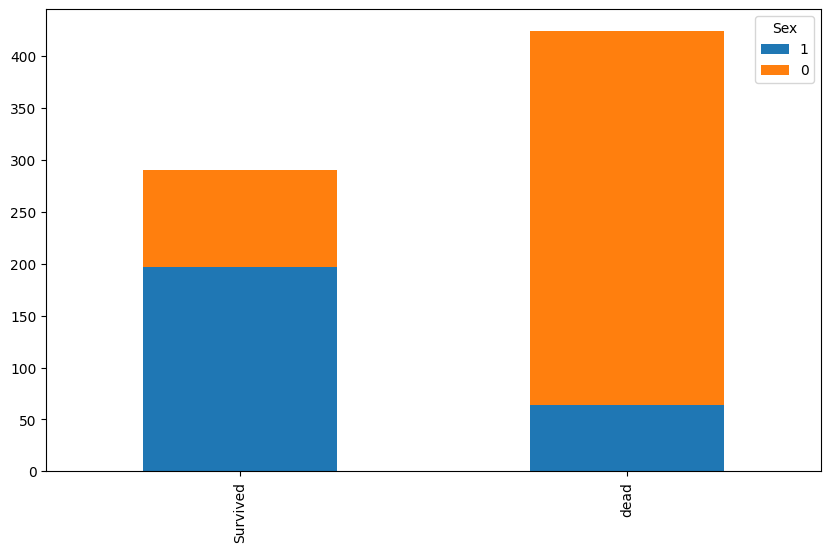

In [ ]:
bar_chart('Sex')

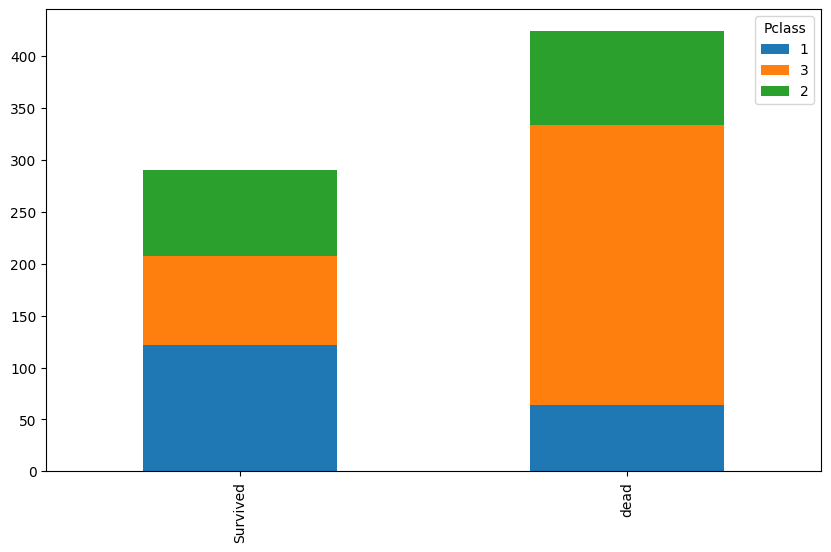

In [ ]:
bar_chart('Pclass')

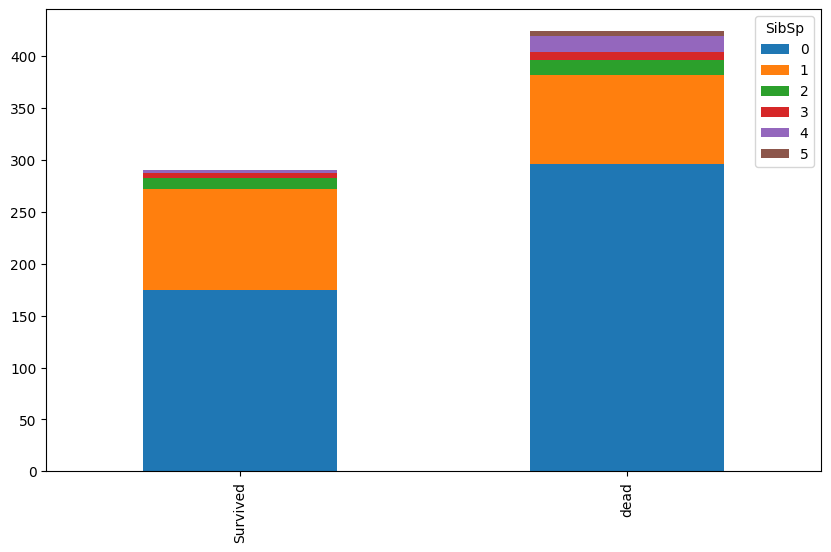

In [ ]:
bar_chart('SibSp')

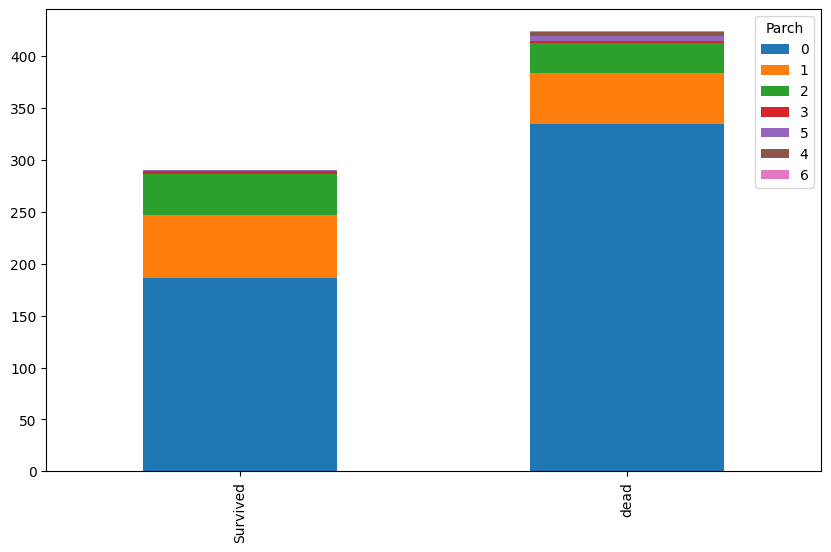

In [ ]:
bar_chart('Parch')

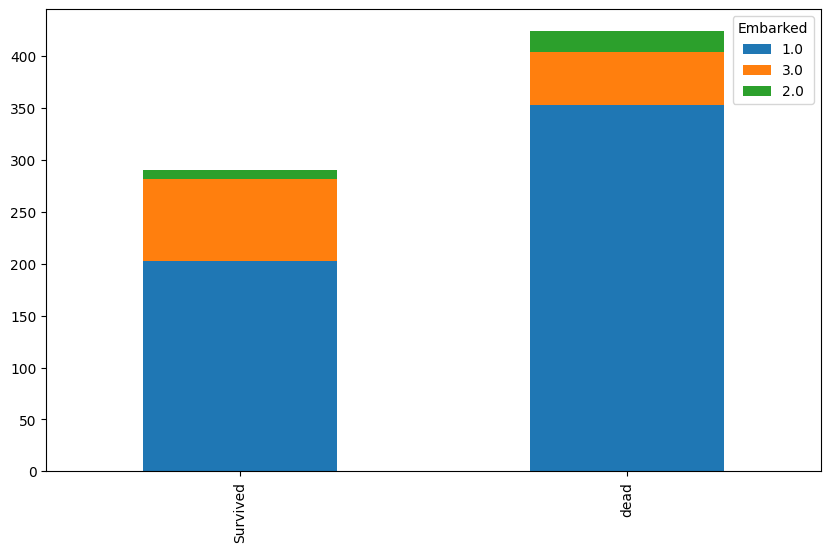

In [ ]:
bar_chart('Embarked')

In [ ]:
train['Cabin'].value_counts()

Cabin
0.0    774
2.0    117
1.0     95
4.0     27
3.0     17
5.0     10
6.0      6
Name: count, dtype: int64

---
### 4.데이터 정제, 전처리 : 특징 처리
---

In [ ]:
# 4.1 Titanic 침몰 상태?
from IPython.display import Image
Image(url='https://static1.squarespace.com/static/5006453fe4b09ef2252ba068/t/5090b249e4b047ba54dfd258/1351660113175/TItanic-Survival-Infographic.jpg')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1046 entries, 0 to 1306
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1046 non-null   int64  
 1   Survived     714 non-null    float64
 2   Pclass       1046 non-null   int64  
 3   Name         1046 non-null   object 
 4   Sex          1046 non-null   int64  
 5   Age          1046 non-null   float64
 6   SibSp        1046 non-null   int64  
 7   Parch        1046 non-null   int64  
 8   Ticket       1046 non-null   int64  
 9   Fare         1046 non-null   float64
 10  Cabin        1046 non-null   float64
 11  Embarked     1046 non-null   float64
 12  Title        1046 non-null   float64
 13  Family       1046 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 122.6+ KB


In [ ]:
# Name : 이름 Mr, Miss, Mrs 추출
# 데이터 전처리 주의 사항 : train data, test data 동시 전처리 
train_test_data = [train, test]
for dataset in train_test_data:
     dataset['Title']=dataset['Name'].str.extract(' ([a-zA-Z]+)\. ', expand=False)

    # train['Title']=train['Name'].str.extract(' ([a-zA-Z]+)\. ', expand=False)
    # test['title']=test['Name'].str.extract(' ([a-zA-Z]+)\. ', expand=False)

C:\Users\tprud\AppData\Local\Temp\ipykernel_3324\3600269305.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Title']=dataset['Name'].str.extract(' ([a-zA-Z]+)\. ', expand=False)


In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,1,7.2500,0.0,1.0,Mr,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,2,71.2833,2.0,3.0,Mrs,1
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,1,7.9250,0.0,1.0,Miss,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,2,53.1000,2.0,1.0,Mrs,1
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,1,8.0500,0.0,1.0,Mr,0


In [ ]:
train['Title'].value_counts()

Title
Mr          581
Miss        210
Mrs         170
Master       53
Rev           8
Dr            7
Col           4
Mlle          2
Major         2
Ms            1
Lady          1
Sir           1
Mme           1
Don           1
Capt          1
Countess      1
Jonkheer      1
Dona          1
Name: count, dtype: int64

In [ ]:
train['Title'].value_counts().index

Index(['Mr', 'Miss', 'Mrs', 'Master', 'Rev', 'Dr', 'Col', 'Mlle', 'Major',
       'Ms', 'Lady', 'Sir', 'Mme', 'Don', 'Capt', 'Countess', 'Jonkheer',
       'Dona'],
      dtype='object', name='Title')

In [ ]:
test['Title'].value_counts().index

Index(['Mr', 'Miss', 'Mrs', 'Master', 'Col', 'Rev', 'Ms', 'Dr', 'Dona'], dtype='object', name='Title')

In [ ]:
train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.655914
1,2,0.479769
2,3,0.239437


In [ ]:
train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
1,1,0.754789
0,0,0.205298


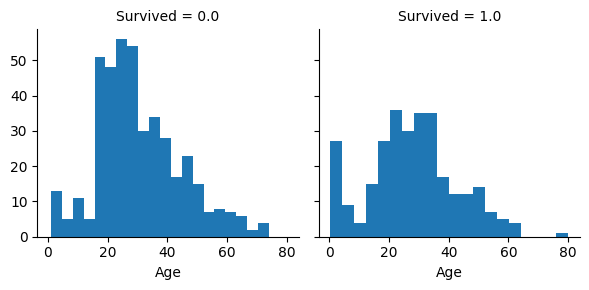

In [ ]:
g = sns.FacetGrid(train, col='Survived')
g.map(plt.hist, 'Age', bins=20)

In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,1,7.2500,0.0,1.0,Mr,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,2,71.2833,2.0,3.0,Mrs,1
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,1,7.9250,0.0,1.0,Miss,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,2,53.1000,2.0,1.0,Mrs,1
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,1,8.0500,0.0,1.0,Mr,0


In [ ]:
title_mapping= {
    'Mr' :0, 'Miss':1,'Mrs':2, 'Master':3, 'Dr':3, 'Rev':3, 'Mlle':3, 'Major':3, 'Col':3,
       'Countess':3, 'Capt':3, 'Ms':3, 'Sir':3, 'Lady':3, 'Mme':3, 'Don':3, 'Jonkheer':3
     
}
train['Title'] = train['Title'].map(title_mapping)
train. head()

C:\Users\tprud\AppData\Local\Temp\ipykernel_3324\3395567840.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Title'] = train['Title'].map(title_mapping)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,1,7.2500,0.0,1.0,0.0,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,2,71.2833,2.0,3.0,2.0,1
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,1,7.9250,0.0,1.0,1.0,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,2,53.1000,2.0,1.0,2.0,1
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,1,8.0500,0.0,1.0,0.0,0


In [ ]:
title_mapping= {
    'Mr' :0, 'Miss':1,'Mrs':2, 'Master':3, 'Dr':3, 'Rev':3, 'Mlle':3, 'Major':3, 'Col':3,
       'Countess':3, 'Capt':3, 'Ms':3, 'Sir':3, 'Lady':3, 'Mme':3, 'Don':3, 'Jonkheer':3
     
}
test['Title'] = test['Title'].map(title_mapping)
test. head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0.0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,2.0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0.0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0.0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,2.0


In [ ]:
test['Title'].isnull().sum()

1

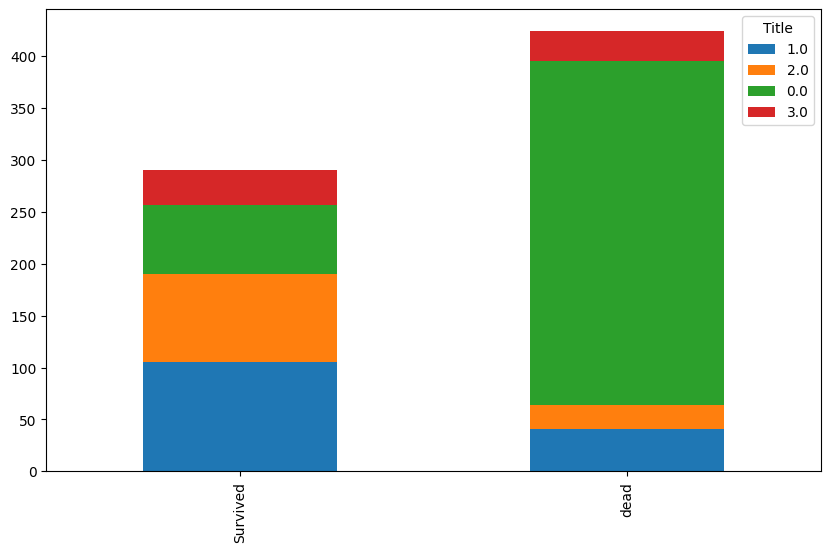

In [ ]:
bar_chart('Title')

In [ ]:
# Name => Title 추출, Name del 
train.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)


C:\Users\tprud\AppData\Local\Temp\ipykernel_3324\824318862.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop('Name', axis=1, inplace=True)


In [ ]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family
0,1,0.0,3,0,22.0,1,0,1,7.2500,0.0,1.0,0.0,1
1,2,1.0,1,1,38.0,1,0,2,71.2833,2.0,3.0,2.0,1
2,3,1.0,3,1,26.0,0,0,1,7.9250,0.0,1.0,1.0,0
3,4,1.0,1,1,35.0,1,0,2,53.1000,2.0,1.0,2.0,1
4,5,0.0,3,0,35.0,0,0,1,8.0500,0.0,1.0,0.0,0


In [ ]:
# sex => Feature
train['Survived'].value_counts()

Survived
0.0    424
1.0    290
Name: count, dtype: int64

In [ ]:
# Sex => Feature
# male : 0, female :1
sex_mapping = {'male':0,'female':1}
train['Sex'] = train['Sex'].map(sex_mapping)
test['Sex'] = test['Sex'].map(sex_mapping)


C:\Users\tprud\AppData\Local\Temp\ipykernel_3324\518793190.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Sex'] = train['Sex'].map(sex_mapping)


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1046 entries, 0 to 1306
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1046 non-null   int64  
 1   Survived     714 non-null    float64
 2   Pclass       1046 non-null   int64  
 3   Sex          0 non-null      float64
 4   Age          1046 non-null   float64
 5   SibSp        1046 non-null   int64  
 6   Parch        1046 non-null   int64  
 7   Ticket       1046 non-null   int64  
 8   Fare         1046 non-null   float64
 9   Cabin        1046 non-null   float64
 10  Embarked     1046 non-null   float64
 11  Title        1045 non-null   float64
 12  Family       1046 non-null   int64  
dtypes: float64(7), int64(6)
memory usage: 114.4 KB


In [ ]:
# bar_chart('Sex')

In [ ]:
data_five_age = pd.read_csv('../result/data_five.csv')

In [ ]:
del data_five_age['Age']
del data_five_age['Embarked']
del data_five_age['Cabin']
del data_five_age['Sex']

In [ ]:
data_five_age.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   891 non-null    int64  
 1   PassengerId  891 non-null    int64  
 2   Survived     891 non-null    int64  
 3   Pclass       891 non-null    int64  
 4   Name         891 non-null    object 
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Female       891 non-null    int64  
 10  Age_hat1     891 non-null    float64
 11  Age_hat2     891 non-null    float64
 12  Age_hat3     891 non-null    float64
 13  Age_hat4     891 non-null    float64
dtypes: float64(5), int64(7), object(2)
memory usage: 97.6+ KB


In [ ]:
data_five_age.head()

,Unnamed: 0,PassengerId,Survived,Pclass,Name,SibSp,Parch,Ticket,Fare,Female,Age_hat1,Age_hat2,Age_hat3,Age_hat4
0,1,1,0,3,"Braund, Mr. Owen Harris",1,0,A/5 21171,7.2500,0,26.112265,24.825432,26.827084,24.515358
1,2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0,PC 17599,71.2833,1,35.635291,37.866451,36.925676,34.110567
2,3,3,1,3,"Heikkinen, Miss. Laina",0,0,STON/O2. 3101282,7.9250,1,21.857192,24.796390,23.452561,25.041155
3,4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,0,113803,53.1000,1,36.319154,38.648803,37.422209,34.429207
4,5,5,0,3,"Allen, Mr. William Henry",0,0,373450,8.0500,0,26.082177,24.791011,26.805238,28.302519


In [ ]:
data_five_age[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [ ]:
data_five_age[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


In [ ]:
# Age => Missing value => Title's(0,1,2,3) median => fillna
train['Age'].fillna(
    train.groupby('Title')['Age'].transform('median')
    , inplace=True
) # inplace = True 일 경우 retrun이 None 


C:\Users\tprud\AppData\Local\Temp\ipykernel_3324\2803816435.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Age'].fillna(


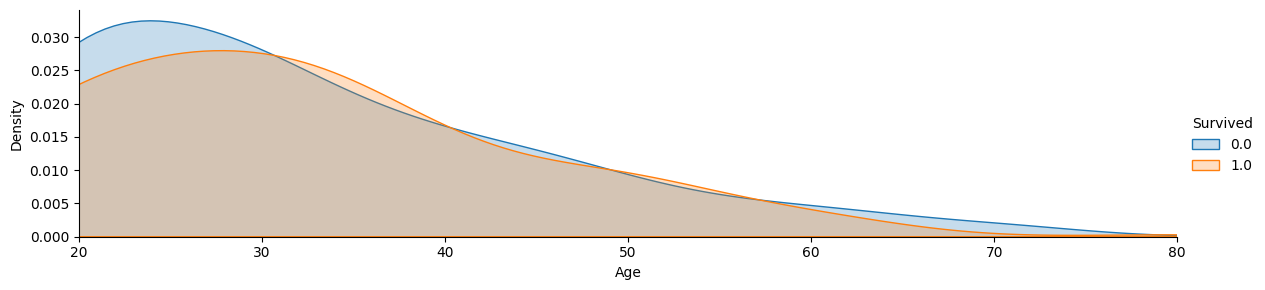

In [ ]:
# 나이에 대한 시각화
facet = sns.FacetGrid(train, hue='Survived',aspect=4) # object create
facet.map(sns.kdeplot, 'Age',fill=True) # 데이터와 차트 연동 
facet.set(xlim=(20, train['Age'].max())) # X축 범위
facet.add_legend() # 범례
plt.show()

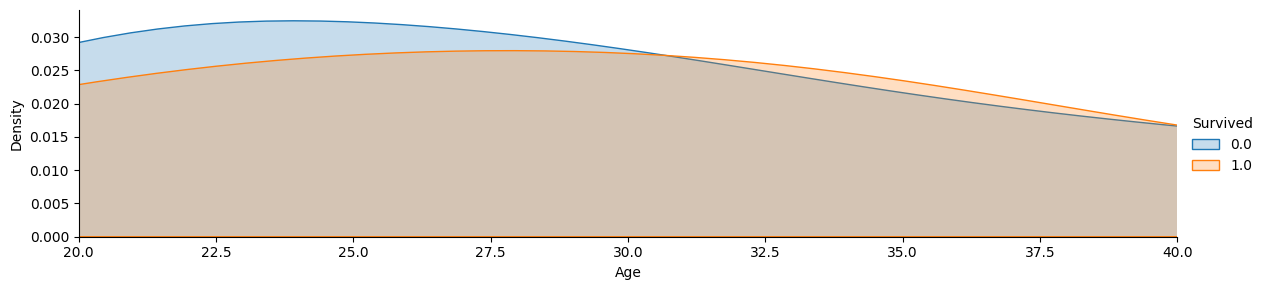

In [ ]:
# 나이에 대한 시각화
facet = sns.FacetGrid(train, hue='Survived',aspect=4) # object create
facet.map(sns.kdeplot, 'Age',fill=True) # 데이터와 차트 연동 
facet.set(xlim=(0, train['Age'].max())) # X축 범위
facet.add_legend() # 범례
plt.xlim(20,40)
plt.show()

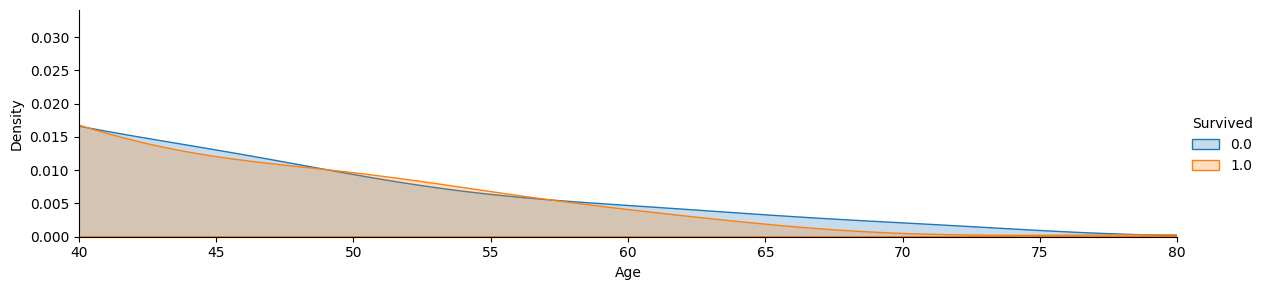

In [ ]:
# 나이에 대한 시각화
facet = sns.FacetGrid(train, hue='Survived',aspect=4) # object create
facet.map(sns.kdeplot, 'Age',fill=True) # 데이터와 차트 연동 
facet.set(xlim=(20, train['Age'].max())) # X축 범위
facet.add_legend() # 범례
plt.xlim(40,80)
plt.show()

In [ ]:
# 4.2 Binning : Age => Categorical
#feature vector map :
# child : 0, 0~16세 
# young : 1, 16<   <=26 
# adult : 2, 26<   <=36
# mid-age : 3, 36<  <=62
# senior : 4, <62
#train_cp = train.copy()
train_test_data = [train, test]
for train_cp in train_test_data:
    train_cp.loc[train_cp['Age']<14,'Age'] = 0
    train_cp.loc[(train_cp['Age']>14)& (train_cp['Age'] <=25),'Age'] = 1
    train_cp.loc[(train_cp['Age']>25)& (train_cp['Age'] <=36),'Age'] = 2
    train_cp.loc[(train_cp['Age']>36)& (train_cp['Age'] <=62),'Age'] = 3
    train_cp.loc[(train_cp['Age']>14),'Age'] = 4


train_cp['Age'].value_counts()


Age
1.0     112
2.0      94
3.0      89
0.0      28
4.0       7
14.0      2
Name: count, dtype: int64

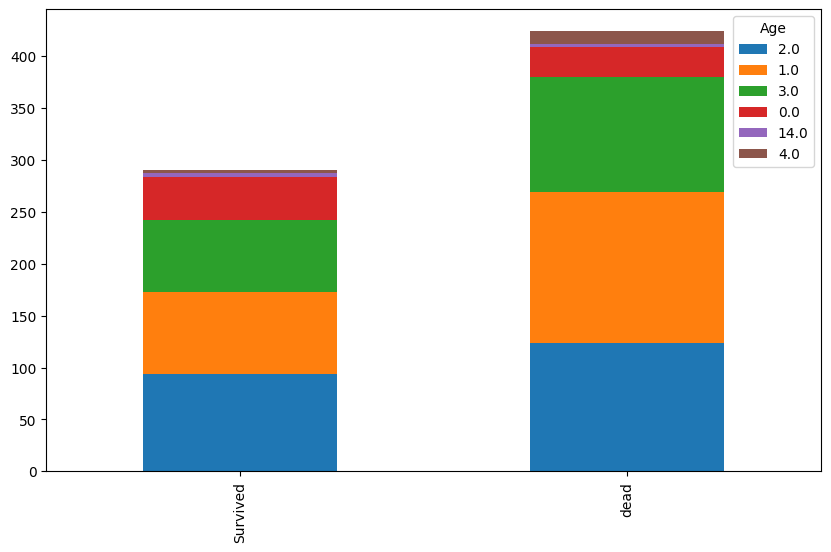

In [ ]:
bar_chart('Age')

In [ ]:
# Embarked 
train[train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family


In [ ]:
#
train[train['Pclass']==1]['Embarked'].value_counts()

Embarked
1.0    153
3.0    128
2.0      3
Name: count, dtype: int64

In [ ]:
Pclass1 = train[train['Pclass']==1]['Embarked'].value_counts()

In [ ]:
Pclass2 = train[train['Pclass']==2]['Embarked'].value_counts()

In [ ]:
Pclass3 = train[train['Pclass']==3]['Embarked'].value_counts()

<Axes: >

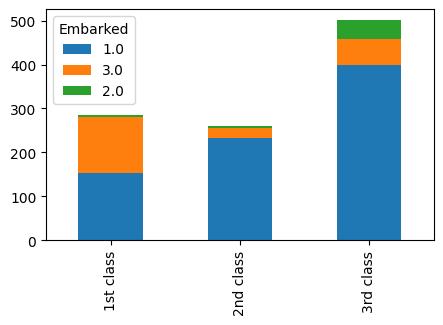

In [ ]:
df = pd.DataFrame([Pclass1, Pclass2, Pclass3])
df.index = ['1st class', '2nd class', '3rd class']
df.plot(kind='bar', stacked=True, figsize=(5,3))

In [ ]:
for dataset in train_test_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

C:\Users\tprud\AppData\Local\Temp\ipykernel_3324\1577112114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Embarked'] = dataset['Embarked'].fillna('S')


In [ ]:
# Embarked value : string => number
embarked_mapping = {'S':0, 'C':1, 'Q':2}
train['Embarked'] = train['Embarked'].map(embarked_mapping)
test['Embarked'] = test['Embarked'].map(embarked_mapping)

C:\Users\tprud\AppData\Local\Temp\ipykernel_3324\304125790.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Embarked'] = train['Embarked'].map(embarked_mapping)


In [ ]:
train[train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family
0,1,0.0,3,NaN,1.0,1,0,1,7.2500,0.0,NaN,0.0,1
1,2,1.0,1,NaN,3.0,1,0,2,71.2833,2.0,NaN,2.0,1
2,3,1.0,3,NaN,2.0,0,0,1,7.9250,0.0,NaN,1.0,0
3,4,1.0,1,NaN,2.0,1,0,2,53.1000,2.0,NaN,2.0,1
4,5,0.0,3,NaN,2.0,0,0,1,8.0500,0.0,NaN,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,1301,NaN,3,NaN,0.0,1,1,3,13.7750,0.0,NaN,1.0,2
1302,1303,NaN,1,NaN,3.0,1,0,3,90.0000,4.0,NaN,2.0,1
1303,1304,NaN,3,NaN,2.0,0,0,1,7.7750,0.0,NaN,1.0,0
1305,1306,NaN,1,NaN,3.0,0,0,3,108.9000,1.0,NaN,NaN,0


In [ ]:
# 4.6 Fare : 가격
test['Fare'].fillna(
    test.groupby('Pclass')['Fare'].transform('median')
    ,  inplace=True
)
test['Fare'].isnull().sum()

0

In [ ]:
train.dtypes

PassengerId      int64
Survived       float64
Pclass           int64
Sex            float64
Age            float64
SibSp            int64
Parch            int64
Ticket           int64
Fare           float64
Cabin          float64
Embarked       float64
Title          float64
Family           int64
dtype: object

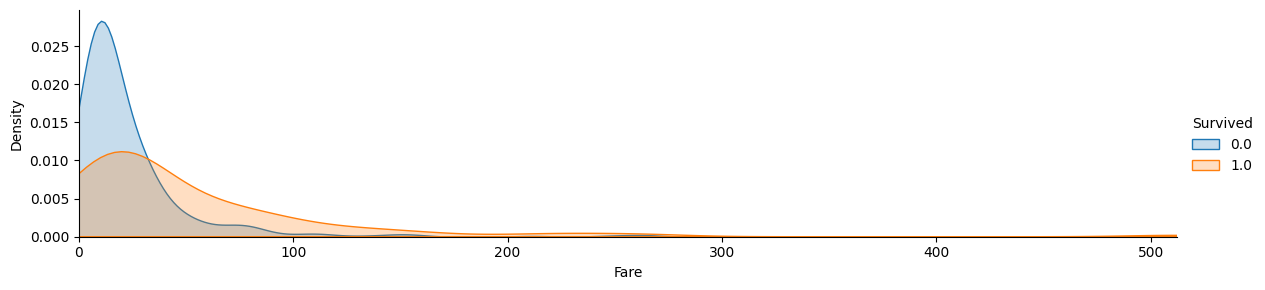

In [ ]:
# Fare Categorical
facet = sns.FacetGrid(
    train # dataFrame
    , hue='Survived' # 비교 조건
    , aspect=4
)
facet.map(sns.kdeplot, 'Fare', fill=True)
facet.set(xlim=(0,train['Fare'].max()))
facet.add_legend()
plt.show()

In [ ]:
train[train['Age'].isnull()]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family


In [ ]:
train.iloc[:10,:]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family
0,1,0.0,3,NaN,1.0,1,0,1,7.2500,0.0,NaN,0.0,1
1,2,1.0,1,NaN,3.0,1,0,2,71.2833,2.0,NaN,2.0,1
2,3,1.0,3,NaN,2.0,0,0,1,7.9250,0.0,NaN,1.0,0
3,4,1.0,1,NaN,2.0,1,0,2,53.1000,2.0,NaN,2.0,1
4,5,0.0,3,NaN,2.0,0,0,1,8.0500,0.0,NaN,0.0,0
6,7,0.0,1,NaN,3.0,0,0,2,51.8625,2.0,NaN,0.0,0
7,8,0.0,3,NaN,0.0,3,1,5,21.0750,0.0,NaN,3.0,4
8,9,1.0,3,NaN,2.0,0,2,3,11.1333,0.0,NaN,2.0,2
9,10,1.0,2,NaN,14.0,1,0,2,30.0708,0.0,NaN,2.0,1
10,11,1.0,3,NaN,0.0,1,1,3,16.7000,5.0,NaN,1.0,2


In [ ]:
train.loc[train['Fare'] <=7.91, 'Fare']=0
train.loc[(train['Fare'] >7.91) & (train['Fare']<=14.454), 'Fare']=1
train.loc[(train['Fare'] >14.454) & (train['Fare']<=30), 'Fare']=2
train.loc[(train['Fare'] >31), 'Fare']=3

test.loc[test['Fare'] <=7.91, 'Fare']=0
test.loc[(test['Fare'] >7.91) & (test['Fare']<=14.454), 'Fare']=1
test.loc[(test['Fare'] >14.454) & (test['Fare']<=30), 'Fare']=2
test.loc[(test['Fare'] >31), 'Fare']=3

train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family
0,1,0.0,3,NaN,1.0,1,0,1,0.0,0.0,NaN,0.0,1
1,2,1.0,1,NaN,3.0,1,0,2,3.0,2.0,NaN,2.0,1
2,3,1.0,3,NaN,2.0,0,0,1,1.0,0.0,NaN,1.0,0
3,4,1.0,1,NaN,2.0,1,0,2,3.0,2.0,NaN,2.0,1
4,5,0.0,3,NaN,2.0,0,0,1,1.0,0.0,NaN,0.0,0


In [ ]:
# # Cabin cjfl
# train['Cabin'] = train['Cabin'].str[:1]
# test['Cabin'] = test['Cabin'].str[:1]
# train['Cabin'].value_counts()

In [ ]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family
0,1,0.0,3,NaN,1.0,1,0,1,0.0,0.0,NaN,0.0,1
1,2,1.0,1,NaN,3.0,1,0,2,3.0,2.0,NaN,2.0,1
2,3,1.0,3,NaN,2.0,0,0,1,1.0,0.0,NaN,1.0,0
3,4,1.0,1,NaN,2.0,1,0,2,3.0,2.0,NaN,2.0,1
4,5,0.0,3,NaN,2.0,0,0,1,1.0,0.0,NaN,0.0,0


In [ ]:
Pclass1 = train[train['Pclass']==1]['Cabin'].value_counts()

In [ ]:
Pclass2 = train[train['Pclass']==2]['Cabin'].value_counts()

In [ ]:
Pclass3 = train[train['Pclass']==3]['Cabin'].value_counts()

<Axes: >

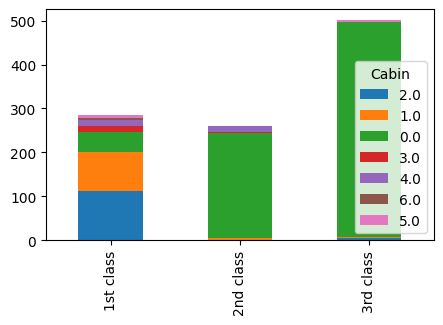

In [ ]:
df= pd.DataFrame([Pclass1, Pclass2, Pclass3])
df.index = ['1st class','2nd class','3rd class']
df.plot(kind='bar', stacked=True, figsize=(5,3))

In [ ]:
cabin_mapping = {'A':0,'B':0.4,'C':0.8,'D':1.2,'E':1.6,'F':2.0,'G':2.4,'T':2.8}
train['Cabin'] = train['Cabin'].map(cabin_mapping)
test['Cabin'] = test['Cabin'].map(cabin_mapping)

C:\Users\tprud\AppData\Local\Temp\ipykernel_3324\134982163.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Cabin'] = train['Cabin'].map(cabin_mapping)


In [ ]:
train.head(),test.head()

(   PassengerId  Survived  Pclass  Sex  Age  SibSp  Parch  Ticket  Fare  Cabin   
 0            1       0.0       3  NaN  1.0      1      0       1   0.0    NaN  \
 1            2       1.0       1  NaN  3.0      1      0       2   3.0    NaN   
 2            3       1.0       3  NaN  2.0      0      0       1   1.0    NaN   
 3            4       1.0       1  NaN  2.0      1      0       2   3.0    NaN   
 4            5       0.0       3  NaN  2.0      0      0       1   1.0    NaN   
 
    Embarked  Title  Family  
 0       NaN    0.0       1  
 1       NaN    2.0       1  
 2       NaN    1.0       0  
 3       NaN    2.0       1  
 4       NaN    0.0       0  ,
    PassengerId  Pclass  Sex  Age  SibSp  Parch   Ticket  Fare  Cabin   
 0          892       3    0  2.0      0      0   330911   0.0    NaN  \
 1          893       3    1  3.0      1      0   363272   0.0    NaN   
 2          894       2    0  3.0      0      0   240276   1.0    NaN   
 3          895       3    0  2.0

In [ ]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,1046.0,655.362333,377.661401,1.0,326.25,662.5,973.75,1307.0
Survived,714.0,0.406162,0.491460,0.0,0.00,0.0,1.00,1.0
Pclass,1046.0,2.207457,0.841497,1.0,1.00,2.0,3.00,3.0
Sex,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,1046.0,1.880497,1.459521,0.0,1.00,2.0,3.00,14.0
SibSp,1046.0,0.502868,0.912167,0.0,0.00,0.0,1.00,8.0
Parch,1046.0,0.420650,0.839750,0.0,0.00,0.0,1.00,6.0
Ticket,1046.0,2.140535,1.666541,1.0,1.00,1.0,3.00,11.0
Fare,1046.0,1.882732,3.023711,0.0,1.00,2.0,3.00,31.0
Cabin,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# test['Title'] = [int(value)for value in test['Title']]

In [ ]:
# fillna
train['Cabin'].fillna(
    train.groupby('Pclass')['Cabin'].transform('median')
    ,inplace=True
)
test['Cabin'].fillna(
    test.groupby('Pclass')['Cabin'].transform('median')
    ,inplace=True
)
test['Age'].fillna(
    test.groupby('Title')['Age'].transform('median')
    , inplace=True
)

C:\Users\tprud\AppData\Local\Temp\ipykernel_3324\764519619.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Cabin'].fillna(


In [ ]:
train['Cabin'].value_counts()

Series([], Name: count, dtype: int64)

In [ ]:
train['Fsize'] = train['SibSp'] + train['Parch'] +1
test['Fsize'] = test['SibSp'] + test['Parch'] +1 

C:\Users\tprud\AppData\Local\Temp\ipykernel_3324\8826594.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Fsize'] = train['SibSp'] + train['Parch'] +1


In [ ]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,1046.0,655.362333,377.661401,1.0,326.25,662.5,973.75,1307.0
Survived,714.0,0.406162,0.491460,0.0,0.00,0.0,1.00,1.0
Pclass,1046.0,2.207457,0.841497,1.0,1.00,2.0,3.00,3.0
Sex,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,1046.0,1.880497,1.459521,0.0,1.00,2.0,3.00,14.0
SibSp,1046.0,0.502868,0.912167,0.0,0.00,0.0,1.00,8.0
Parch,1046.0,0.420650,0.839750,0.0,0.00,0.0,1.00,6.0
Ticket,1046.0,2.140535,1.666541,1.0,1.00,1.0,3.00,11.0
Fare,1046.0,1.882732,3.023711,0.0,1.00,2.0,3.00,31.0
Cabin,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
f_mapping = {1:0,2:0.4,3:0.8,4:1.2,5:1.6,6:2.0,7:2.4,8:2.8,9:3.2,10:3.6,11:4.0}
train['Fsize'] = train['Fsize'].map(f_mapping)
test['Fsize'] = test['Fsize'].map(f_mapping)
train.describe().T

C:\Users\tprud\AppData\Local\Temp\ipykernel_3324\2584216181.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Fsize'] = train['Fsize'].map(f_mapping)


,count,mean,std,min,25%,50%,75%,max
PassengerId,1046.0,655.362333,377.661401,1.0,326.25,662.5,973.75,1307.0
Survived,714.0,0.406162,0.491460,0.0,0.00,0.0,1.00,1.0
Pclass,1046.0,2.207457,0.841497,1.0,1.00,2.0,3.00,3.0
Sex,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,1046.0,1.880497,1.459521,0.0,1.00,2.0,3.00,14.0
SibSp,1046.0,0.502868,0.912167,0.0,0.00,0.0,1.00,8.0
Parch,1046.0,0.420650,0.839750,0.0,0.00,0.0,1.00,6.0
Ticket,1046.0,2.140535,1.666541,1.0,1.00,1.0,3.00,11.0
Fare,1046.0,1.882732,3.023711,0.0,1.00,2.0,3.00,31.0
Cabin,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'Family', 'Fsize'],
      dtype='object')

In [ ]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,1046.0,655.362333,377.661401,1.0,326.25,662.5,973.75,1307.0
Survived,714.0,0.406162,0.491460,0.0,0.00,0.0,1.00,1.0
Pclass,1046.0,2.207457,0.841497,1.0,1.00,2.0,3.00,3.0
Sex,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,1046.0,1.880497,1.459521,0.0,1.00,2.0,3.00,14.0
SibSp,1046.0,0.502868,0.912167,0.0,0.00,0.0,1.00,8.0
Parch,1046.0,0.420650,0.839750,0.0,0.00,0.0,1.00,6.0
Ticket,1046.0,2.140535,1.666541,1.0,1.00,1.0,3.00,11.0
Fare,1046.0,1.882732,3.023711,0.0,1.00,2.0,3.00,31.0
Cabin,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    int64  
 3   Age          418 non-null    float64
 4   SibSp        418 non-null    int64  
 5   Parch        418 non-null    int64  
 6   Ticket       418 non-null    object 
 7   Fare         418 non-null    float64
 8   Cabin        93 non-null     float64
 9   Embarked     418 non-null    int64  
 10  Title        417 non-null    float64
 11  Fsize        418 non-null    float64
dtypes: float64(5), int64(6), object(1)
memory usage: 39.3+ KB


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    int64  
 3   Age          418 non-null    float64
 4   SibSp        418 non-null    int64  
 5   Parch        418 non-null    int64  
 6   Ticket       418 non-null    object 
 7   Fare         418 non-null    float64
 8   Cabin        93 non-null     float64
 9   Embarked     418 non-null    int64  
 10  Title        417 non-null    float64
 11  Fsize        418 non-null    float64
dtypes: float64(5), int64(6), object(1)
memory usage: 39.3+ KB


In [ ]:
dataset_pq = dataset.drop(['Ticket','SibSp', 'Parch'], axis=1)
target = train['Survived']

dataset_pq.shape, target.shape

((418, 9), (1046,))

In [ ]:
# train_data


In [ ]:
train.shape

(1046, 14)

In [ ]:
test.shape

(418, 12)

In [ ]:
features_drop = ['Ticket', 'SibSp', 'Parch']

train = train.drop(features_drop, axis=1)
test = test.drop(features_drop, axis=1)

## Modelling

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

In [ ]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=42)
clf = KNeighborsClassifier(n_neighbors=13) # Model object
scoring = 'accuracy' # 평가지표 : 정확도
score = cross_val_score(clf, dataset_pq, target, cv=k_fold, n_jobs=-1, scoring=scoring)
print(score.mean())

ValueError: Found input variables with inconsistent numbers of samples: [418, 1046]

In [ ]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=42)
clf = DecisionTreeClassifier() # Model object
scoring = 'accuracy' # 평가지표 : 정확도
score = cross_val_score(clf, dataset_pq, target, cv=k_fold, n_jobs=-1, scoring=scoring)
print(score.mean())

ValueError: Found input variables with inconsistent numbers of samples: [418, 1046]

In [ ]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=42)
clf = RandomForestClassifier(n_estimators=100, max_depth=3) # Model object
scoring = 'accuracy' # 평가지표 : 정확도
score = cross_val_score(clf, dataset_pq, target, cv=k_fold, n_jobs=-1, scoring=scoring)
print(score.mean())

ValueError: Found input variables with inconsistent numbers of samples: [418, 1046]

In [ ]:
train.shape

(891, 10)

In [ ]:
test.shape

(418, 9)

In [ ]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Fsize
0,1,0,3,0,1.0,0.0,2.0,0,0,0.4
1,2,1,1,1,3.0,3.0,0.8,1,2,0.4
2,3,1,3,1,2.0,1.0,2.0,0,1,0.0
3,4,1,1,1,2.0,3.0,0.8,0,2,0.4
4,5,0,3,0,2.0,1.0,2.0,0,0,0.0


In [ ]:
test.head()

,PassengerId,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Fsize
0,892,3,0,2.0,0.0,2.0,2,0.0,0.0
1,893,3,1,3.0,0.0,2.0,0,2.0,0.4
2,894,2,0,3.0,1.0,2.0,2,0.0,0.0
3,895,3,0,2.0,1.0,2.0,0,0.0,0.0
4,896,3,1,1.0,1.0,2.0,0,2.0,0.8


In [ ]:
test.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
Fare           0
Cabin          0
Embarked       0
Title          1
Fsize          0
dtype: int64

## Xg boost

In [ ]:
xgboost  = XGBClassifier()
xgboost.fit(train_data, target)
prediction = xgboost.predict(test)

# submission = pd.DataFrame({
#         "PassengerId": test["PassengerId"],
#         "Survived": Y_pred
#     })
# submission.to_csv('./titanic-4.csv', index=False)


In [ ]:
answer = pd.read_csv('../답/올리면 뒤짐!!.csv')
del answer['PassengerId']
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(prediction, answer)
print(accuracy)

0.7488038277511961


---------
## testing


In [ ]:
# clf = RandomForestClassifier(n_estimators=300, max_depth=5)
# clf.fit(train_data,target)# 학습

# prediction = clf.predict(test) # 테스트 데이터로 예측값 추출

In [ ]:
# submission = pd.DataFrame({
#     'PassengerId':test['PassengerId']
#     ,'Survived':prediction
# })

In [ ]:
# submission.to_csv('submission.csv',index=False)

In [ ]:
# test.loc[test['Title'].isnull(), 'Title'] = 0.0
# test.isnull().sum()